# Easily Calculate ground state Energy benchmarks

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from molbench.orchestrator import Orchestrator
from molbench.utils.omegaconf import load_molecule_cfg

## 1. Load Molecule Setting from Configure File


This section loads a molecule definition (geometry, basis, charge/spin, and active-space settings) from a YAML config via `load_molecule_cfg`, then builds an `Orchestrator` for running electronic-structure methods.

In [2]:
def initialize_molecule(molecule_name: str, overrides: dict | None = None):
    config = load_molecule_cfg(molecule_name, overrides=overrides)
    executor = Orchestrator(
        geometry=config.molecule.geometry,
        basis=config.molecule.basis,
        nelecas=config.molecule.nelecas,
        norbcas=config.molecule.norbcas,
        spin=config.molecule.spin,
        charge=config.molecule.charge,
    )
    return config, executor

In [ ]:
molecule_name = "N2"
config, executor = initialize_molecule(molecule_name)
print(config.molecule)

{'distance': 1.595, 'basis': 'sto-3g', 'nelecas': 4, 'norbcas': 6, 'spin': 0, 'charge': 0, 'geometry': [['Li', [0.0, 0.0, 0.0]], ['H', [0.0, 0.0, 1.595]]]}


## 2. Compute ground state Energy

To simplify the process of creating initial states from diverse outputs, I implements wrappers around a wide variety of quantum chemistry methods. This notebook discusses PySCF-based methods -- for density-matrix renormalization group (DMRG).

In particular, It implements a series of methods do_xxx, where xxx is a name of a method like cisd or `dmrg``. All these methods take a PySCF Hartree-Fock object as input plus whatever is needed to setup the solver, and all return four items: the solver object (or something to be converted into a wavefunction), list of energies, list of 
 expectation values, and list of 
 expectation values.

## Hartree–Fock (HF)

Hartree–Fock treats electron–electron interactions in a **mean-field (one-electron) approximation** and solves the self-consistent field (SCF) equations to obtain molecular orbitals.
- What you get: a baseline ground-state energy and a **reference state** for correlated methods (CCSD/CISD/CASCI/DMRG)
- Caveat: electron correlation is largely missing, so accuracy can degrade for strongly correlated systems

In [4]:
hf_result = executor.do_hf(verbose=0)
hf_result.print_summary()

Energy: -7.862023860127114
Spin squared (S^2): 0
Spin projection (S_z): 0
Number of determinants: 1
Top 10 determinants:
123456  |  123456  |  coeff
----------------------------------------
110000  |  110000  |  1.000000


## CCSD (Coupled Cluster Singles and Doubles)

CCSD captures **dynamic correlation** by exponentiating single and double excitation operators around an HF reference.
- Strengths: **size-extensive**, typically accurate for weak-to-moderate correlation
- Cost: computationally and memory intensive; can be expensive with large basis sets or large active spaces

In [5]:
ccsd_result = executor.do_ccsd(verbose=0)
ccsd_result.print_summary()

Energy: -7.882391437616428
Spin squared (S^2): 0.0
Spin projection (S_z): 0.0
Number of determinants: 40
Top 10 determinants:
123456  |  123456  |  coeff
----------------------------------------
110000  |  110000  |  0.987075
100001  |  100001  |  -0.113595
101000  |  100001  |  0.059094
100001  |  101000  |  0.059024
110000  |  101000  |  0.038434
101000  |  110000  |  0.038434
101000  |  101000  |  -0.035868
100010  |  100010  |  -0.027121
100100  |  100100  |  -0.027121
011000  |  011000  |  -0.003760


## CISD (Configuration Interaction Singles and Doubles)

CISD represents the wavefunction as a linear combination of Slater determinants including single and double excitations from an HF reference.
- Strengths: conceptually simple; correlation appears directly in determinant coefficients
- Caveat: as a truncated CI, CISD is generally **not size-extensive** (the energy does not scale correctly with system size)

In [6]:
cisd_result = executor.do_cisd(verbose=0)
cisd_result.print_summary()

Energy: -7.882388614941493
Spin squared (S^2): 6.14289837852711e-34
Spin projection (S_z): 0.0
Number of determinants: 35
Top 10 determinants:
123456  |  123456  |  coeff
----------------------------------------
110000  |  110000  |  0.987113
100001  |  100001  |  -0.113567
101000  |  100001  |  0.059234
100001  |  101000  |  0.059234
101000  |  110000  |  0.038414
110000  |  101000  |  0.038414
101000  |  101000  |  -0.034373
100010  |  100010  |  -0.027110
100100  |  100100  |  -0.027110
011000  |  011000  |  -0.003748


## CASCI: Complete Active Space Configuration Interaction

## CASCI (Complete Active Space CI)

CASCI performs (FCI-equivalent) exact diagonalization **within a chosen active space** (norbcas, nelecas), providing the exact solution inside that active space.
- Strengths: good for **static correlation** (e.g., bond dissociation), though results depend strongly on the active-space choice
- Caveat: cost grows exponentially with active-space size, so it is limited to small-to-moderate active spaces

In [7]:
result_casci = executor.do_casci(verbose=0)
result_casci.print_summary()

Energy: -7.882401932287121
Spin squared (S^2): 5.98904647860462e-14
Spin projection (S_z): 1.1968204205459188e-13
Number of determinants: 69
Top 10 determinants:
123456  |  123456  |  coeff
----------------------------------------
110000  |  110000  |  0.987089
100001  |  100001  |  -0.113589
100001  |  101000  |  0.059295
101000  |  100001  |  0.059295
101000  |  110000  |  0.038486
110000  |  101000  |  0.038486
101000  |  101000  |  -0.034451
100100  |  100100  |  -0.027166
100010  |  100010  |  -0.027166
011000  |  011000  |  -0.003762


## DMRG (Density Matrix Renormalization Group)

DMRG is a tensor-network method that represents the wavefunction as a **matrix product state (MPS)** and approximately solves the many-body problem within an active space.
- Accuracy control: mainly improved by increasing the **bond dimension** (here: schedule bond_dims)
- Strengths: can reach high accuracy for larger active spaces when entanglement is relatively low
- Caveats: performance depends on bond dimension, orbital ordering, and convergence/tuning parameters

In [8]:
# DMRG schedule format: [bond_dims, n_sweeps, noises, thresholds]
# For small molecules like H2, low bond dimension (10-30) is sufficient
schedule = [
    [10, 20, 30],          # bond dimensions
    [5, 5, 5],             # n_sweeps at each bond dim
    [1e-4, 1e-5, 0.0],     # noise values
    [1e-6, 1e-8, 1e-10],   # Davidson thresholds
]
result_dmrg = executor.do_dmrg(
    schedule=schedule,
    verbose=0,
    max_mem=512,                # Allowed 512 MB memory for DMRG calculation
    workdir="/tmp/dmrg_calc_tmp",  # Use local tmp instead of Google Drive
)
result_dmrg.print_summary()

Energy: -7.882401932255443
Spin squared (S^2): 2.4427464378762923e-12
Spin projection (S_z): 0
Number of determinants: 69
Top 10 determinants:
123456  |  123456  |  coeff
----------------------------------------
110000  |  110000  |  0.987090
100001  |  100001  |  -0.113589
101000  |  100001  |  0.059293
100001  |  101000  |  0.059293
101000  |  110000  |  0.038477
110000  |  101000  |  0.038477
101000  |  101000  |  -0.034446
100010  |  100010  |  -0.027166
100100  |  100100  |  -0.027166
011000  |  011000  |  -0.003762


## 3. Calculate Energy Curve

In [9]:
bond_lengths = np.linspace(0.8, 2.0, 50)
energies = {"hf": [], "ccsd": [], "cisd": [], "casci": [], "dmrg": []}

In [10]:
for bond_length in bond_lengths:
    config, executor = initialize_molecule(molecule_name, overrides={"distance": float(bond_length)})

    # HF
    hf_result = executor.do_hf(verbose=0)
    energies["hf"].append(hf_result.energy)

    # CCSD
    ccsd_result = executor.do_ccsd(verbose=0)
    energies["ccsd"].append(ccsd_result.energy)

    # CISD
    cisd_result = executor.do_cisd(verbose=0)
    energies["cisd"].append(cisd_result.energy)

    # CASCI
    result_casci = executor.do_casci(verbose=0)
    energies["casci"].append(result_casci.energy)

    # DMRG
    schedule = [
        [20, 40, 60],          # bond dimensions
        [5, 5, 5],             # n_sweeps at each bond dim
        [1e-4, 1e-5, 0.0],     # noise values
        [1e-6, 1e-8, 1e-10],   # Davidson thresholds
    ]
    result_dmrg = executor.do_dmrg(schedule=schedule, verbose=0)
    energies["dmrg"].append(result_dmrg.energy)
    

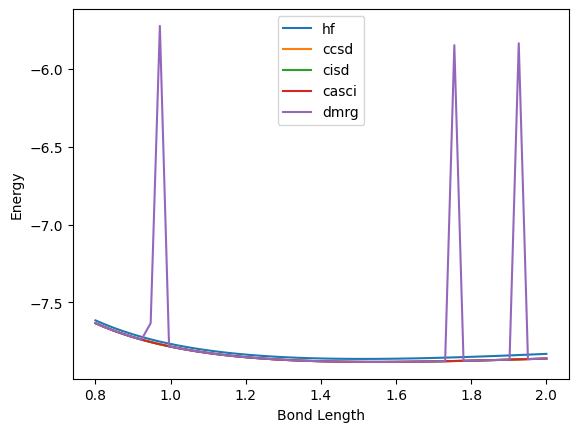

In [11]:
for method, energy_list in energies.items():
    plt.plot(bond_lengths, energy_list, label=method)
plt.legend()
plt.xlabel("Bond Length")
plt.ylabel("Energy")
plt.show()